# Get contents extracted from images using OpenAI API

In [25]:
import os, base64, json
from PIL import Image, ImageDraw
from io import BytesIO
from IPython.display import display
from openai import OpenAI
from dotenv import load_dotenv
load_dotenv()

openaikey = os.getenv('OPENAI_API_KEY')

# function to produce byte image for API call
def resize_and_encode_image(image_path, target_width):#, output_path):
    # Open the image file
    with Image.open(image_path) as image:
        # Calculate the new height while maintaining the aspect ratio
        width, height = image.size
        aspect_ratio = height / width
        target_height = int(target_width * aspect_ratio)

        # Resize the image
        resized_image = image.resize((target_width, target_height), Image.Resampling.LANCZOS)

        # Save the resized image to a file
        # resized_image.save(output_path, format="JPEG")

        # Convert the resized image to bytes
        buffered = BytesIO()
        resized_image.save(buffered, format="JPEG")
        image_bytes = buffered.getvalue()

        # Encode the image bytes as base64
        encoded_image = base64.b64encode(image_bytes).decode("utf-8")

        return encoded_image

In [2]:
# client_openai = OpenAI(openaikey)
client_openai = OpenAI(api_key=openaikey)
openai_model = 'gpt-4o'
max_tokens = 4096 # max output at one time
temperture = 0

num_pages = '0'

## JASON format, including layout & bbox

In [22]:
system_prompt = [
    "You are a software programmer tasked with labeling of document images for document layout analysis.",
    "Given images of pages of a document, you need to create a response in json format, describing the layout of the document. The document is a decision of a court of law in Korea.\n",
    "If more than one, the images of the pages of the document will be provided sequentially in the user prompt. \n",
    "The json response should include 'page_number' starting with 1, 'image_dimension' in a list of width and height, and 'elements' in the format of list of dictionaries, as the top level keys. \n",
    "The values of 'image_dimension' is the size of the image in pixel. The default size of all images is 768 by 1085. If the size of the provided image is different, provide the size you detected and add 'irregular' as the third element of the list. \n",
    "The values of 'elements' is a list of elements in the image. \n",
    "Each element is in a python dictionary format and has 'category', 'id', 'bbox', and optionally 'content' as keys. \n",
    "The possible values of 'id' and 'category' are as follows, with each category described in a separate line, with explanation in parenthesis: \n",
    "1: 'Text' (A paragraph of texts. A single paragraph should be treated as a single element. If a paragraph spans over multiple pages, treat the parts of the paragraph that are in different pages as separate elements.",
    "Sometime a paragraph is contained in a single line.) \n"
    "2: 'Title' (Title of a secion of text. Titles almost always begin with a numerical or character symbol, and the symbol is usually, but not always, followed by a period or a type of parenthesis, for example '1. 원고의 주장' or '가) 원고의 주장'.",
    "There are some instances where the title does not begin with a symbol, but in this case it will likley be left-justified and differentiated from the rest of the text by typeface, font, or spacing.",
    "The length of a title is usually much shorter than a paragraph and almost never spans multiple lines. There are instances where a title is immediately followed by a subtitle or a subtitles in the next line. Mark subtitles also as 'Title') \n",
    "3: 'Figure (Image within the provided document image. Sometimes a image is in a different column from the text. You may see seomtimes that an image of a table is in the document. In this case mark the image of a table as 'Figure', not 'Table'.",
    "If an element can be both Figure and 'header_image' described below, use 'header_image'. \n)",
    "4: 'Figure caption' (A short caption for a figure that may precede or follow a Figure.) \n",
    "5: 'Table' (Tables have multiple cells in a rectangular border. If a rectangle that contains texts and/or figures does not have multiple cells, mark it as 'box_quote', not 'Table'.) \n",
    "6: 'Table caption' (A short caption for a table that may precede or follow a Table.) \n",
    "7: 'Header' (Texts that are located on the top of the page, and contextually not a part of the main body texts of the document.) \n",
    "8: 'Footer', (All footers in the provided document image will be at the very bottom of the page and will contain the page number.) \n",
    "9: 'Reference', (In the convention used here, 'Reference' is a footnote. It will always be at the bottom of the page but above 'Footer'. There will be a horizontal line separating the main body texts and footnotes.) \n",
    "10: 'Equation', (Mathmatically equasion) \n",
    "11: 'block_quote', (A quote that is part of the main body of the document, but not enclosed within a rectangle or quotation marks. There are usually a contextual signal that indicates the beginning of a block_quote, such as '계약서는 다음과 같다'.",
    "If other elements are included in the area where a 'block_quote' is, do not mark other elements. In other words, a 'block_quote' should not have any other element inside.) \n"
    "12: 'box_quote', (Similar to block_quote, but the difference is that the block_quote is enclosed within a rectangle. The upper horizontal line signifies the beginning of a box_quote. The lower horizontal line sigifies the end of a block quote.",
    "There are instances where a box_quote spans over multiple pages. In this case the orizontal lines of the rectangle may not be present. Like block_quote, if other elements are included in the area where a 'box_quote' is, do not mark other elements.) \n",
    "13: 'caption_block', (This is all text content above the section header that reads '주문'. If there's a Header in the page, a caption_block does not include the Header. This block contains metadata of the case such as '사건', '피고인', and so forth.",
    "Mark the entire rectangular area fits the description as a 'caption_block'. Note that sometimes a caption block spans over multiple pages, in which case the '주문' section header will appear in the page where the captio block ends.) \n",
    "14: 'claim', (This is a special type os Text, which signifies a claim in a patent. Some patent cases quote the underlying disputed patent claims. Mark individual claim as 'claim'. Do not concurrently mark this as 'Text'.) \n",
    "15: 'fn_marker', (This is a superscripted number that indicates a footnote.) \n",
    "16: 'header_image', (This is an image that is located at the top left corner of the page, usually left to a header_text. The text part of the header should be marked 'Header' as described above.) \n",
    "17: 'list_item', (If you see a list of items, mark the entire list as 'list_item'. If what seems to be the first or last item in a list is shown at the bottom or top of the page, mark the item as 'Text', even if it may be a part of a 'list_item'.)",
    "18: 'section_header', (This is a header in the body text that's center-justfied to denote the beginning of a major section. There are always more than one section header in a document, and the first one is always '주문'.",
    "Other sections headers include '이유', '청구취지', '청구취지 및 항소취지', and so on.",
    "The '주문' section header is located just below the caption block. You may see some spacing inbetween characters in a section header, for example '주   문'.) \n",
    "19: 'sig_block', (This is the signature block located usually at the end of a case, where the name(s) of the judge(s) are listed with a '판사' or '재판장' marker. Treat the entire area as a single block, that contains all names of the judges.",
    "If a sig_block spans over two pages, mark each part as a 'sig_block'. This block does not always come at the end of a case, if there is an attachment to the case. An attachement will have a '별지' marker on the top of the first page of the attachement.",
    "Do not mark the attachment with anything, which mean you should not do anything with the part that comes after the sig_block.) \n"
    "The values of 'bbox' follow the COCO dtaset convention: the x and y coordinates of the top-left corner and the width and height of the box. Make sure to consider the size of the provided image when determiing the values of 'bbox'.",
    "Keep in mind that the width of the image is 768 pixels and the height of the image is 1085 pixels, and determine the values of bbox accordingly.\n",
    "Optionally, you may be instructed to extract texts that fall within the bbox area. The user input will have a que 'Extract texts' for this optional instruction. If you do not see this instruction, do not extract texts. \n",
    "If a bbox represents a Figure, then put 'figure' as value for the 'content' key. \n",
    "If other elements are located in the area where 'caption_block', 'block_quote', 'sig_block', or 'box_quote', do not mark the elements within these 4 elements. The 4 elements should not have other elements inside. \n",
    "Everything above taken into account, your respose should look like this: \n",
    """{
        'page_number': 1,
        'image_dimension': [1240, 1754],
        'elements': [
            {
                'id':1,
                'category':'Text',
                'bbox':[120,451,1137,378],
                'content': '따라서 피고인의 양형부당 주장에 대하여 나아가 판단함이 없이 형사소송법 제364조 제6항에 의하여 원심판결을 파기하고 변론을 거쳐 다시 다음과 같이 판결한다.'
            },
            {
                'id':8,
                'category':'Figure',
                'bbox':[118,451,1137,378],
                'content':'figure'
            },
        ]
    }"""
]

user_prompt = [
    "Here are the page(s) of a korean court case. Perform tasks described in the system prompt."
]


In [ ]:
systemPrompt = ' '.join(system_prompt)
userPrompt = ' '.join(user_prompt) + ' Extract texts.'

# print(systemPrompt + '\n\n')
# print(userPrompt)

In [66]:
# Specify the image path and target width
image_root = "./testdata"
org_folder = "CONVERTED_JPEG"
resized_folder = 'resized4openai'
image_inputs = (
    [
        'adobe_table_광주지법_2019구합10788_판결서_0.jpg',
        'adobe_table_광주지법_2019구합10788_판결서_1.jpg',
        'adobe_특허법원 2017허8459_0.jpg',
        'adobe_특허법원 2017허8459_1.jpg'
    ]
)

target_page = image_inputs[3]

image_path = f"{image_root}/{org_folder}/{target_page}"
output_path = f"{image_root}/{resized_folder}/{target_page}"
target_width = 768

print(image_path)
print(output_path)

# Call the function to resize and encode the image
encoded_image = resize_and_encode_image(f"{image_path}", target_width)#, output_path)

./testdata/CONVERTED_JPEG/adobe_특허법원 2017허8459_1.jpg
./testdata/resized4openai/adobe_특허법원 2017허8459_1.jpg


[{'url': ''}]
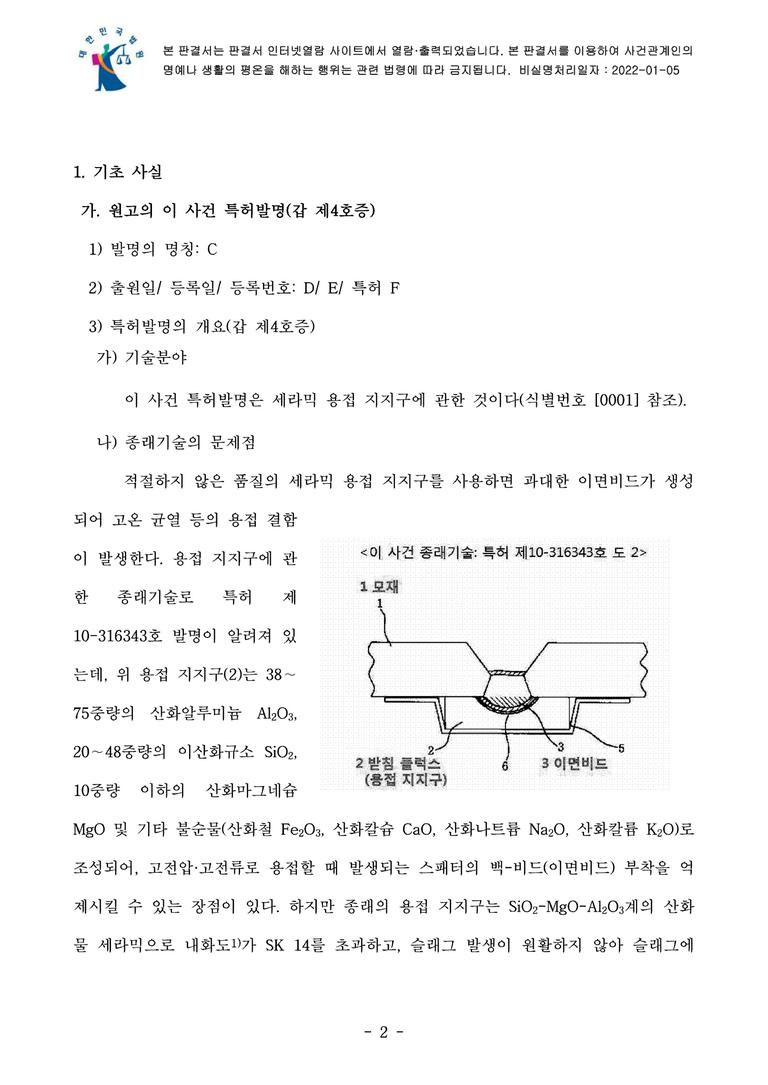

In [67]:
image_urls = []
with open(f"{image_root}/{resized_folder}/{target_page}", "rb") as image_file:
    encoded_image = base64.b64encode(image_file.read()).decode("utf-8")
    image_urls.append({
        "url": f"data:image/jpeg;base64,{encoded_image}"
    })
image_urls

In [68]:
payload = [
    {
        "role": "system",
        "content": [
            {
                "type": "text",
                "text": systemPrompt
            }
        ]
    },
    {
        "role": "user",
        "content": [
            {
                "type": "text",
                "text": userPrompt,
            },
            {
                "type": "image_url",
                "image_url": {
                    # "url": f"data:image/jpeg;base64,{encoded_image}"
                    "url": f"data:image/jpeg;base64,"
                    + base64.b64encode(open(f'{image_root}/{resized_folder}/{target_page}', "rb").read()).decode(
                        "utf-8"
                    ),
                }
            },
        ],
    }
]

print(payload[0]["content"][0])

response = client_openai.chat.completions.create(
    model=openai_model,
    messages=payload,
    max_tokens=max_tokens,
    temperature=0
)

print(response.usage)

{'type': 'text', 'text': "You are a software programmer tasked with labeling of document images for document layout analysis. Given images of pages of a document, you need to create a response in json format, describing the layout of the document. The document is a decision of a court of law in Korea.\n If more than one, the images of the pages of the document will be provided sequentially in the user prompt. \n The json response should include 'page_number' starting with 1, 'image_dimension' in a list of width and height, and 'elements' in the format of list of dictionaries, as the top level keys. \n The values of 'image_dimension' is the size of the image in pixel. The default size of all images is 768 by 1085. If the size of the provided image is different, provide the size you detected and add 'irregular' as the third element of the list. \n The values of 'elements' is a list of elements in the image. \n Each element is in a python dictionary format and has 'category', 'id', 'bbox'

In [69]:
json_str = response.to_dict()['choices'][0]['message']['content'].lstrip("```json\n").rstrip("```")
data_dict = json.loads(json_str)
data_dict

{'page_number': 1,
 'image_dimension': [768, 1085],
 'elements': [{'id': 1,
   'category': 'Header',
   'bbox': [50, 30, 668, 50],
   'content': '본 판결서는 판결서 인터넷열람 사이트에서 열람·출력되었습니다. 본 판결서를 이용하여 사건관계인의 명예나 생활의 평온을 해하는 행위는 관련 법령에 따라 금지됩니다. 비실명처리일자: 2022-01-05'},
  {'id': 2,
   'category': 'Title',
   'bbox': [50, 100, 668, 30],
   'content': '1. 기초 사실'},
  {'id': 3,
   'category': 'Title',
   'bbox': [50, 140, 668, 30],
   'content': '가. 원고의 이 사건 특허발명(갑 제4호증)'},
  {'id': 4,
   'category': 'Text',
   'bbox': [50, 180, 668, 30],
   'content': '1) 발명의 명칭: C'},
  {'id': 5,
   'category': 'Text',
   'bbox': [50, 220, 668, 30],
   'content': '2) 출원일/ 등록일/ 등록번호: D/ E/ 특허 F'},
  {'id': 6,
   'category': 'Text',
   'bbox': [50, 260, 668, 30],
   'content': '3) 특허발명의 개요(갑 제4호증)'},
  {'id': 7,
   'category': 'Text',
   'bbox': [50, 300, 668, 30],
   'content': '가) 기술분야'},
  {'id': 8,
   'category': 'Text',
   'bbox': [50, 340, 668, 30],
   'content': '이 사건 특허발명은 세라믹 용접 지지구에 관한 것이다(식별번호 [0001] 참조).'}

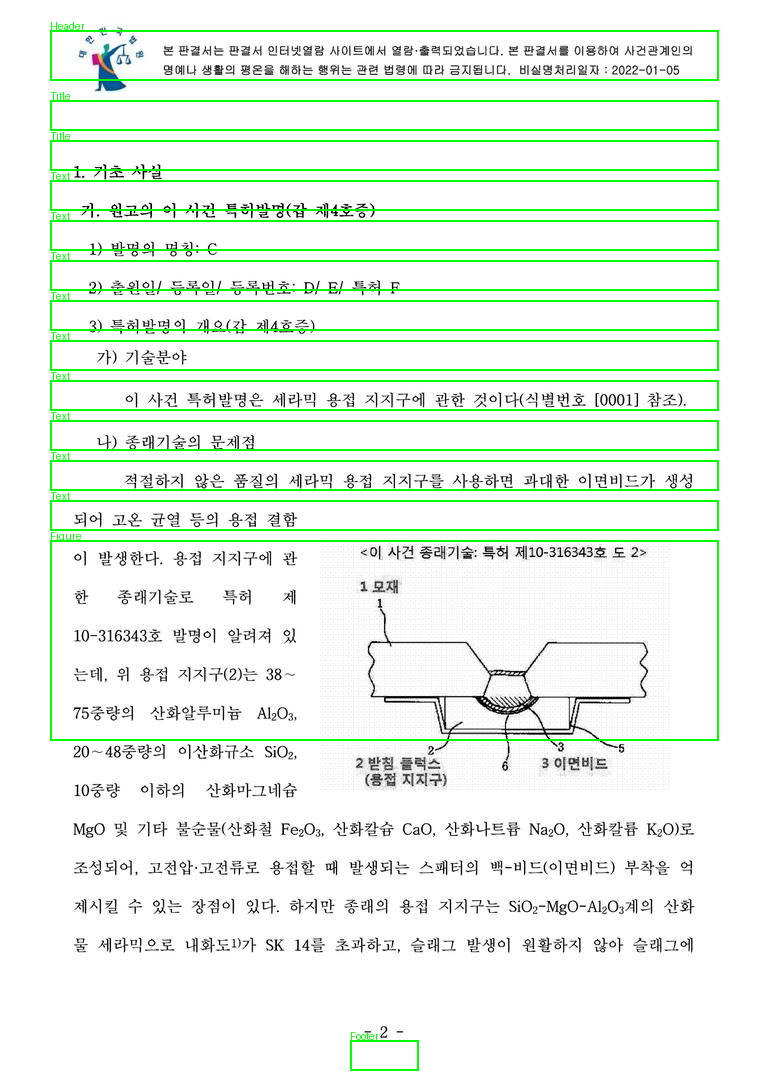

In [70]:
image_path = f"{image_root}/{resized_folder}/{target_page}"
bounding_boxes = data_dict['elements']
def draw_bounding_boxes(image_path, bounding_boxes):
    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)

    for bbox_info in bounding_boxes:
        bbox = bbox_info['bbox']
        x, y, w, h = bbox

        draw.rectangle((x, y, x + w, y + h), outline=(0, 255, 0), width=2)

        category = bbox_info['category']
        draw.text((x, y - 10), category, fill=(0, 255, 0))

    display(image)

draw_bounding_boxes(image_path, bounding_boxes)

## Only texts, line by line

In [26]:
system_prompt = [
    "You are a document processor tasked with extracting texts from images, who pays a great attention to details.",
    "Given images of pages of a document, you need to create a response with texts from the images. The document is a decision of a court of law in Korea.\n",
    "If more than one, the images of the pages of the document will be provided sequentially in the user prompt. \n",
    "The json response is a list of dictionaries. Each dictionary should include 'image_dimension' in the form of a list of width and height, and 'texts' in the format of list of strings, as the top level keys. \n",
    "The value of 'image_dimension' is the size of the image in pixel. The default size of all images is 768 by 1085. If the size of the provided image is different, provide the size you detected and add 'irregular' as the third element of the 'image_dimension' list. \n",
    "The value of 'texts' is the texts you extracted from the image. The texts shold be extracted paragraph by paragraph. Each paragraph should become a separate element of the list. \n"
    "If a paragraph spans over multiple pages, put the entire paragraph in a single line. Sometime a paragraph is contained in a single line.) \n"
    "If a line is in the form that does not fit the definition of a paragraph, like title, section header, or list item, put this line in a separate line. \n",
    "Sometimes you may see unnecesary spaces between characters in these non-paragraph line. Remove these spaces. \n",
    "If you see a graphical element, just ignore them and do not put any texts from it in the response. You may see sometimes that an image of a table is in the document. In this case, also ignore the texts from the image. \n",
    "Also ingnore captions that are asscociated with the graphical element. \n"
    "If you see a header or footer (like page number), ignore these as well. \n"
    "If you see a table, just extract the texts and ignore the cell or table borders. Each row should be in a separate line, with tab inbetween cells \n",
    "If you see a table caption, include this in a separate line \n"
    "Everything above taken into account, your respose should look like this: \n",
    """[
            {
                'image_dimension': [768, 1085],
                'texts': [
                    '서울중앙지방법원',
                    '원고(반소피고) 주식회사 A',
                    '피고(반소원고) 법무법인 B',
                    '변론 종결 2015. 3. 19',
                    '판결 선고 2015. 4. 16',
                    '주문',
                    '1. 피고(반소원고)는 원고(반소피고)에게 85,750,252원 및 이에 대하여 2013. 4. 3.부터2015. 4. 16.까지는 연 6%의, 그 다음 날부터 다 갚는 날까지는 연 20%의 각 비율로 계산한 돈을 지급하라.',
                    '2. 원고(반소피고)의 나머지 본소청구와 피고(반소원고)의 반소청구를 모두 기각한다.',
                    '주문',
                    '따라서 피고인의 양형부당 주장에 대하여 나아가 판단함이 없이 형사소송법 제364조 제6항에 의하여 원심판결을 파기하고 변론을 거쳐 다시 다음과 같이 판결한다.'.
            },
            {
                'image_dimension': [768, 1085],
                'texts': [
                    '서울고등법원',
                    '원고 주식회사 A',
                    '피고 법무법인 B',
                    '변론 종결 2022. 3. 19',
                    '판결 선고 2022. 4. 16',
                    '주문',
                    '원고 청구를 모두 기각한다.',
                    '이유',
                    '다음과 같이 판결한다.'.
            }
    ]"""
]

user_prompt = [
    "Here are the page(s) of a korean court case. Perform tasks described in the system prompt."
]


In [27]:
systemPrompt = ' '.join(system_prompt)
userPrompt = ' '.join(user_prompt)

# print(systemPrompt + '\n\n')
# print(userPrompt)

In [28]:
# get case names (to group pages from same case together)
image_root = "./testdata"
org_folder = "UPT_PDF_SAMPLE_JPEG"

imagelist = os.listdir(f"{image_root}/{org_folder}")
filelist = list(set(['_'.join(f.split('_')[:-1]) for f in imagelist]))
filedict = dict()
for f in filelist:
    filedict[f"{f}"] = sorted([i for i in imagelist if i.startswith(f)])
filedict

{'scan_대전지법_2014가단227529_판결서': ['scan_대전지법_2014가단227529_판결서_0.jpg',
  'scan_대전지법_2014가단227529_판결서_1.jpg',
  'scan_대전지법_2014가단227529_판결서_2.jpg'],
 'scan_안산지원_2015가단5545_판결서': ['scan_안산지원_2015가단5545_판결서_0.jpg',
  'scan_안산지원_2015가단5545_판결서_1.jpg',
  'scan_안산지원_2015가단5545_판결서_2.jpg'],
 'scan_대구고법_2014나4744_판결서': ['scan_대구고법_2014나4744_판결서_0.jpg',
  'scan_대구고법_2014나4744_판결서_1.jpg',
  'scan_대구고법_2014나4744_판결서_2.jpg',
  'scan_대구고법_2014나4744_판결서_3.jpg',
  'scan_대구고법_2014나4744_판결서_4.jpg',
  'scan_대구고법_2014나4744_판결서_5.jpg',
  'scan_대구고법_2014나4744_판결서_6.jpg',
  'scan_대구고법_2014나4744_판결서_7.jpg',
  'scan_대구고법_2014나4744_판결서_8.jpg',
  'scan_대구고법_2014나4744_판결서_9.jpg'],
 'scan_성남지원_2014가단27196_판결서': ['scan_성남지원_2014가단27196_판결서_0.jpg',
  'scan_성남지원_2014가단27196_판결서_1.jpg',
  'scan_성남지원_2014가단27196_판결서_2.jpg',
  'scan_성남지원_2014가단27196_판결서_3.jpg',
  'scan_성남지원_2014가단27196_판결서_4.jpg'],
 'scan_서울고법_2014나2023155_판결서': ['scan_서울고법_2014나2023155_판결서_0.jpg',
  'scan_서울고법_2014나2023155_판결서_1.jpg',
  'scan_서울고법_2014나2

In [29]:
# Specify the image path and target width

imagenames = filedict[filelist[0]]

image_root = "./testdata"
org_folder = "UPT_PDF_SAMPLE_JPEG"
resized_folder = 'UPT_PDF_SAMPLE_JPEG_resized4openai'
image_inputs = (imagenames)
#     [
#         'adobe_table_광주지법_2019구합10788_판결서_0.jpg',
#         'adobe_table_광주지법_2019구합10788_판결서_1.jpg',
#     ]
# )

for file in filedict.keys():
    imagenames_4_file = filedict[file]
    image_urls = []
    for imgg in imagenames_4_file:
        image_path = f"{image_root}/{org_folder}/{imgg}"
        target_width = 768

        print(image_path)

        # Call the function to resize and encode the image
        encoded_image = resize_and_encode_image(f"{image_path}", target_width)#, output_path)
        image_urls.append({
            "url": f"data:image/jpeg;base64,{encoded_image}"
        })

    break
    image_urls

./testdata/UPT_PDF_SAMPLE_JPEG/scan_대전지법_2014가단227529_판결서_0.jpg
./testdata/UPT_PDF_SAMPLE_JPEG/scan_대전지법_2014가단227529_판결서_1.jpg
./testdata/UPT_PDF_SAMPLE_JPEG/scan_대전지법_2014가단227529_판결서_2.jpg


[{'url': ''},
 {'url': ''},
 {'url': ''}]
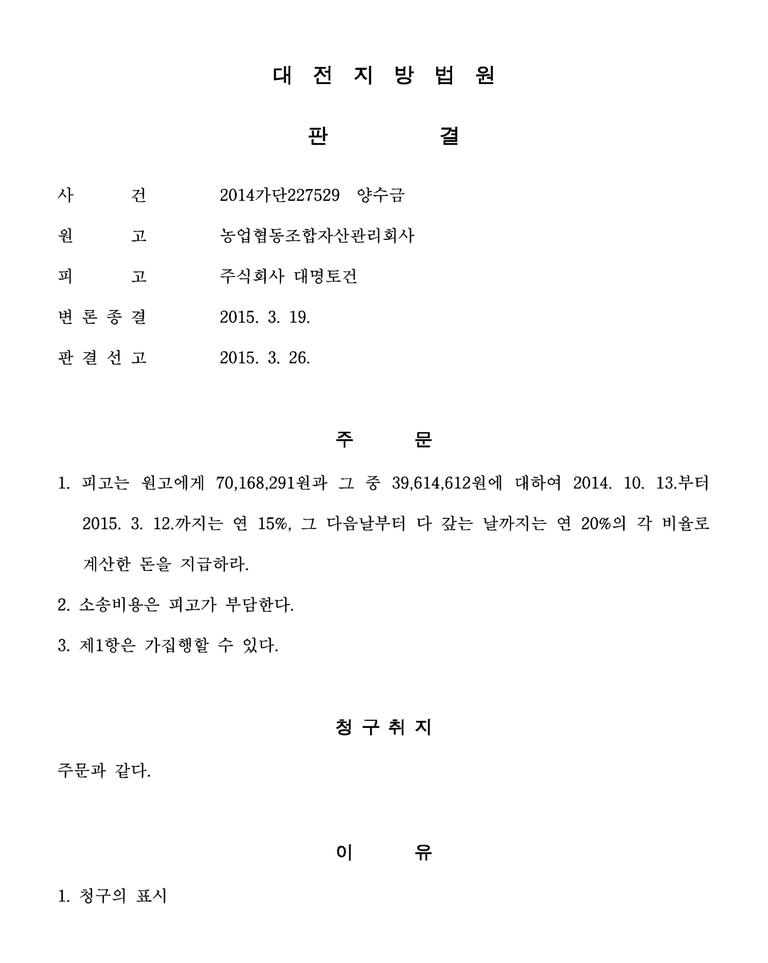
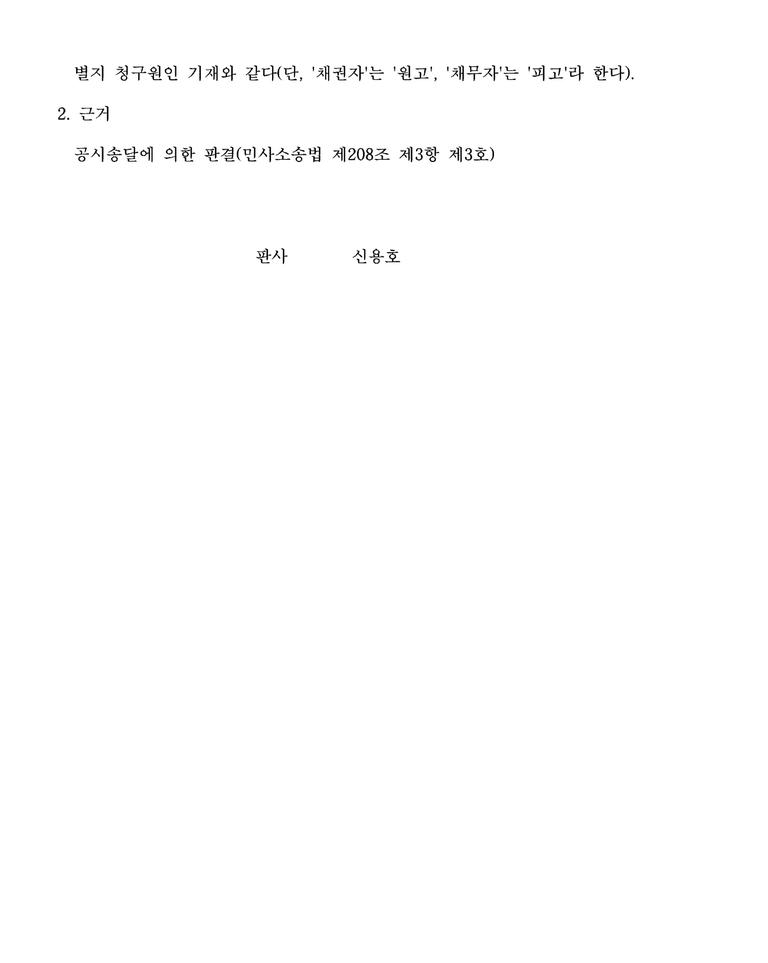
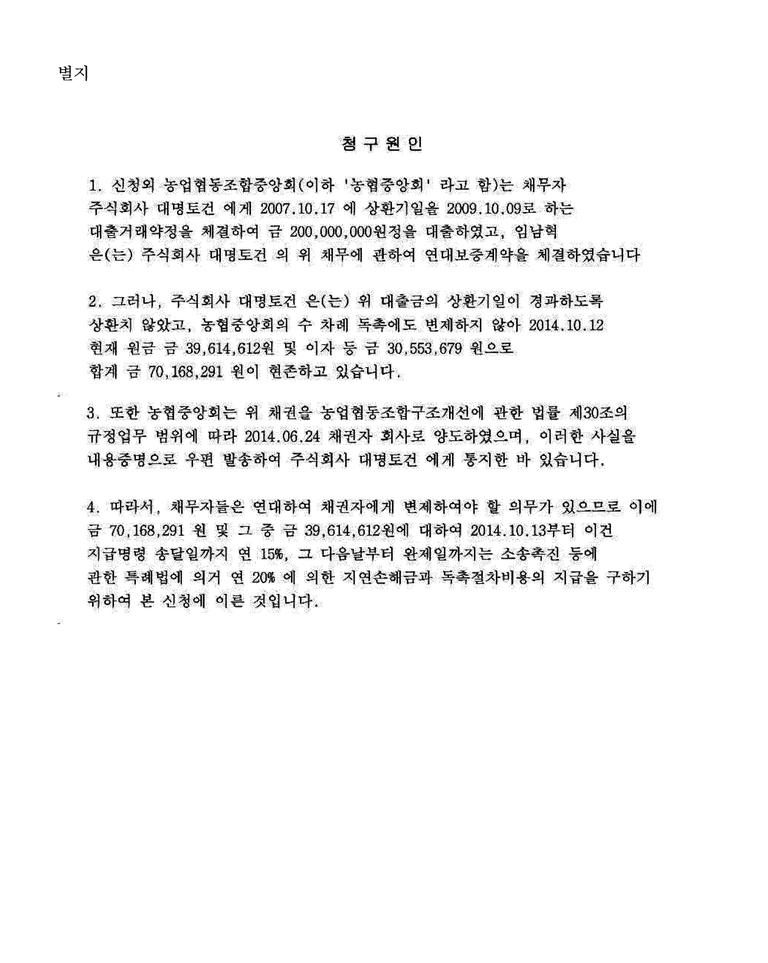

In [30]:
image_urls

[{'role': 'system', 'content': [{'type': 'text', 'text': "You are a document processor tasked with extracting texts from images, who pays a great attention to details. Given images of pages of a document, you need to create a response with texts from the images. The document is a decision of a court of law in Korea.\n If more than one, the images of the pages of the document will be provided sequentially in the user prompt. \n The json response is a list of dictionaries. Each dictionary should include 'image_dimension' in the form of a list of width and height, and 'texts' in the format of list of strings, as the top level keys. \n The value of 'image_dimension' is the size of the image in pixel. The default size of all images is 768 by 1085. If the size of the provided image is different, provide the size you detected and add 'irregular' as the third element of the 'image_dimension' list. \n The value of 'texts' is the texts you extracted from the image. The texts shold be extracted p
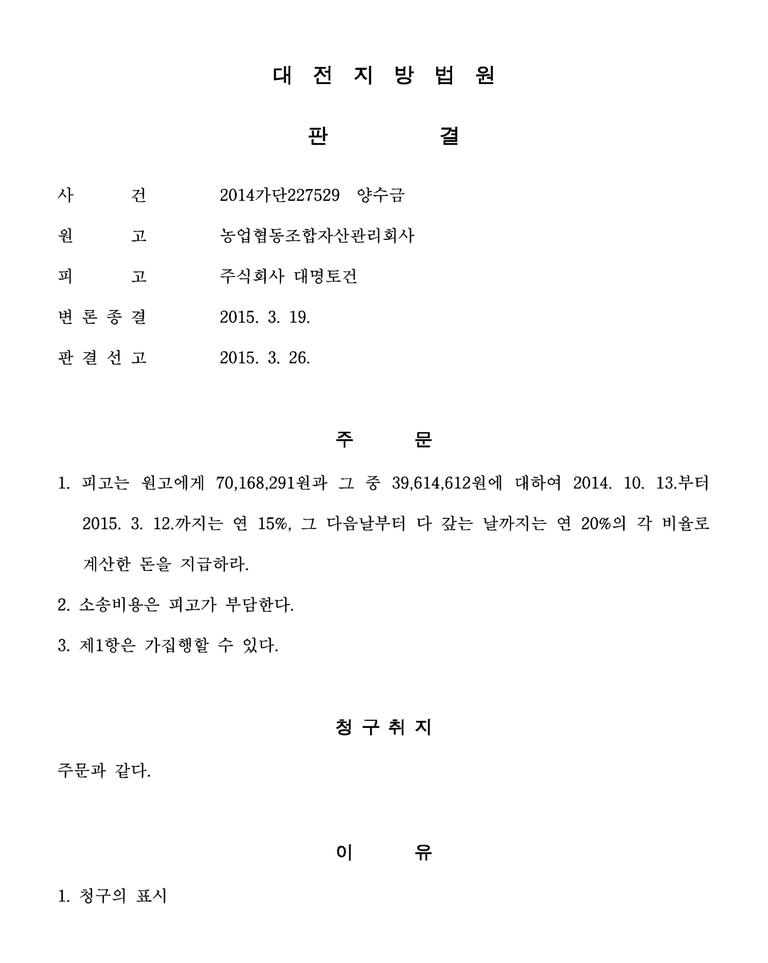
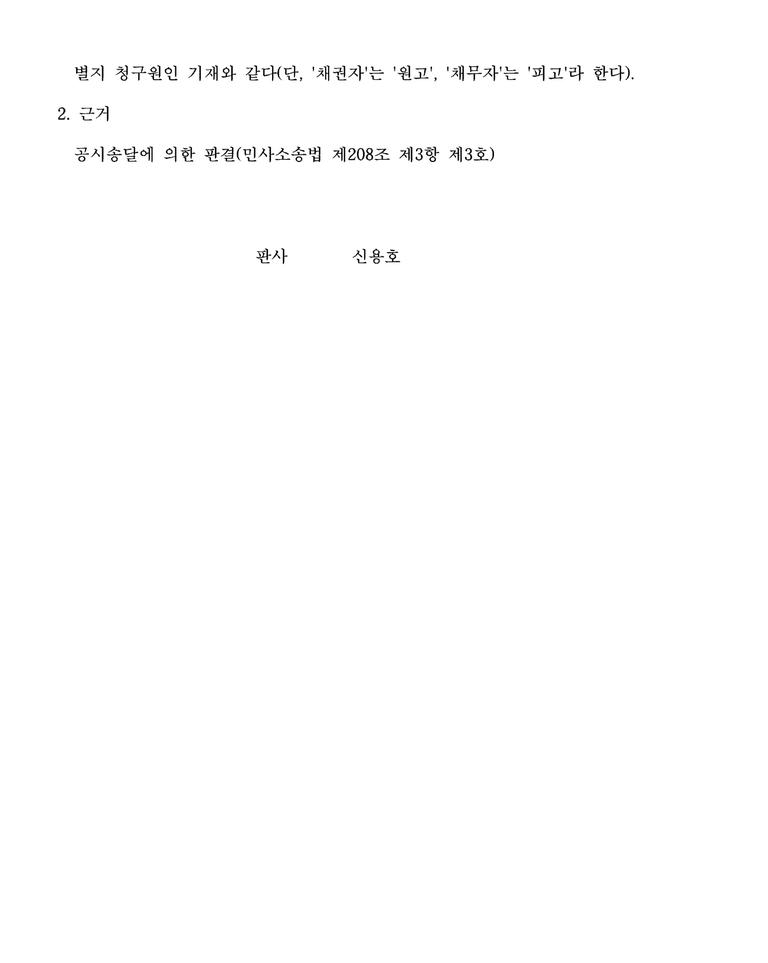
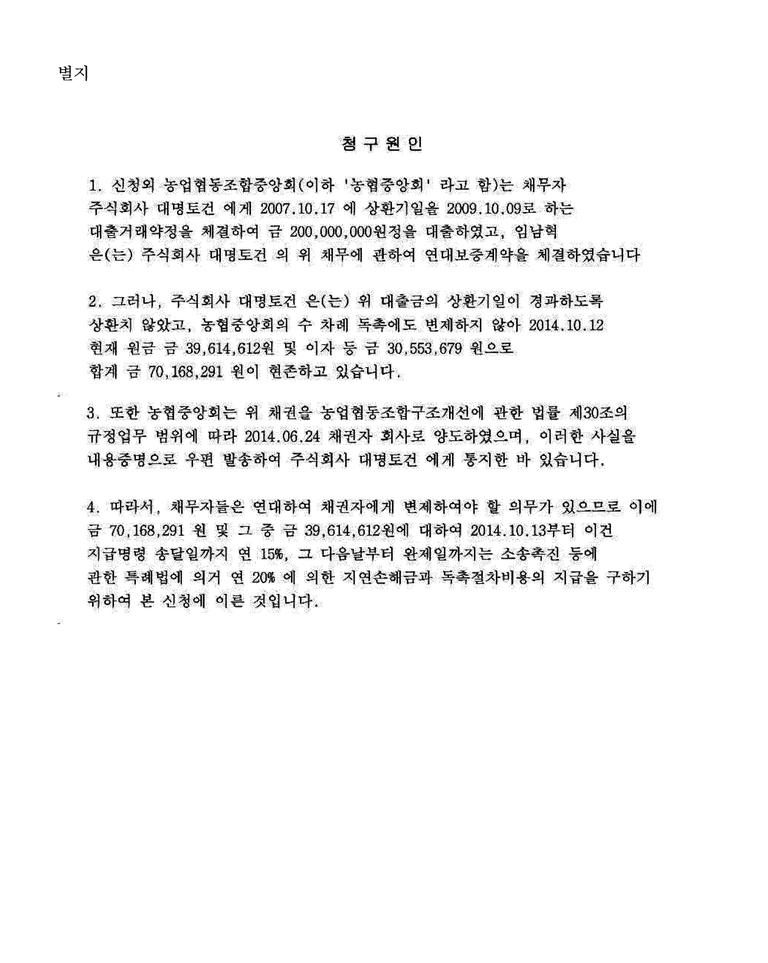

In [31]:
payload = [
    {
        "role": "system",
        "content": [
            {
                "type": "text",
                "text": systemPrompt
            }
        ]
    },
    {
        "role": "user",
        "content": [
            {
                "type": "text",
                "text": userPrompt,
            },
            {
                "type": "image_url",
                "image_url": image_urls
            },
        ],
    }
]

print(payload)


In [32]:

response = client_openai.chat.completions.create(
    model=openai_model,
    messages=payload,
    max_tokens=max_tokens,
    temperature=0
)

print(response.usage)

APIConnectionError: Connection error.

In [ ]:
json_str = response.to_dict()['choices'][0]['message']['content'].lstrip("```json\n").rstrip("```")
data_dict = json.loads(json_str)
data_dict